Solo extraer sin mas

In [82]:
import pdfplumber
import pandas as pd
from collections import defaultdict

def extraer_pdf_manteniendo_formato(ruta_pdf):
    """
    Extrae información del PDF manteniendo el formato original
    usando diferentes estrategias según el contenido
    """

    with pdfplumber.open(ruta_pdf) as pdf:
        contenido_completo = []

        for num_pagina, pagina in enumerate(pdf.pages, 1):
            print(f"\n--- Página {num_pagina} ---")

            # ESTRATEGIA 1: Extracción básica manteniendo layout
            texto_con_layout = extraer_con_layout(pagina)

            # ESTRATEGIA 2: Extracción por coordenadas (mantiene posiciones)
            texto_por_coordenadas = extraer_por_coordenadas(pagina)

            # ESTRATEGIA 3: Extracción de tablas si las hay
            tablas = extraer_tablas_formato(pagina)

            # ESTRATEGIA 4: Extracción por clusters de texto
            texto_por_clusters = extraer_por_clusters(pagina)

            contenido_pagina = {
                'pagina': num_pagina,
                'layout_preservado': texto_con_layout,
                'por_coordenadas': texto_por_coordenadas,
                'tablas': tablas,
                'clusters': texto_por_clusters
            }

            contenido_completo.append(contenido_pagina)

    return contenido_completo

def extraer_con_layout(pagina):
    """
    Estrategia 1: Usar layout=True para mantener espaciado
    """
    try:
        # layout=True mantiene espacios y posiciones relativas
        texto = pagina.extract_text(layout=True)
        return texto
    except Exception as e:
        print(f"Error en extracción con layout: {e}")
        return None

def extraer_por_coordenadas(pagina):
    """
    Estrategia 2: Extraer caracteres con sus coordenadas y reconstruir
    """
    try:
        chars = pagina.chars
        if not chars:
            return None

        # Agrupar caracteres por líneas basándose en coordenada Y
        lineas = defaultdict(list)

        for char in chars:
            # Redondear Y para agrupar caracteres en la misma línea
            y_redondeada = round(char['y0'], 1)
            lineas[y_redondeada].append(char)

        # Ordenar líneas de arriba hacia abajo (Y mayor a Y menor)
        lineas_ordenadas = sorted(lineas.keys(), reverse=True)

        texto_reconstruido = []
        for y in lineas_ordenadas:
            # Ordenar caracteres en la línea de izquierda a derecha
            chars_linea = sorted(lineas[y], key=lambda x: x['x0'])

            # Reconstruir texto de la línea manteniendo espacios
            linea_texto = ""
            x_anterior = None

            for char in chars_linea:
                if x_anterior is not None:
                    # Calcular espacios basándose en distancia
                    distancia = char['x0'] - x_anterior
                    if distancia > char.get('width', 5) * 1.5:  # Si hay gap significativo
                        espacios = max(1, int(distancia / char.get('width', 5)))
                        linea_texto += ' ' * min(espacios, 10)  # Limitar espacios

                linea_texto += char['text']
                x_anterior = char['x0'] + char.get('width', 0)

            if linea_texto.strip():  # Solo agregar líneas no vacías
                texto_reconstruido.append(linea_texto)

        return '\n'.join(texto_reconstruido)

    except Exception as e:
        print(f"Error en extracción por coordenadas: {e}")
        return None

def extraer_tablas_formato(pagina):
    """
    Estrategia 3: Extraer tablas manteniendo formato
    """
    try:
        # Configuración para detectar tablas mejor
        table_settings = {
            "vertical_strategy": "lines_strict",
            "horizontal_strategy": "lines_strict",
            "snap_tolerance": 3,
            "join_tolerance": 3
        }

        # Intentar con configuración estricta primero
        tablas = pagina.extract_tables(table_settings)

        # Si no encuentra tablas, intentar con configuración más flexible
        if not tablas:
            table_settings_flex = {
                "vertical_strategy": "text",
                "horizontal_strategy": "text",
                "snap_tolerance": 5,
                "join_tolerance": 5
            }
            tablas = pagina.extract_tables(table_settings_flex)

        tablas_formateadas = []
        for i, tabla in enumerate(tablas):
            if tabla:
                # Convertir a DataFrame para mejor formato
                df = pd.DataFrame(tabla[1:], columns=tabla[0] if tabla[0] else None)
                tablas_formateadas.append({
                    'tabla_num': i + 1,
                    'dataframe': df,
                    'raw_data': tabla
                })

        return tablas_formateadas

    except Exception as e:
        print(f"Error en extracción de tablas: {e}")
        return []

def extraer_por_clusters(pagina):
    """
    Estrategia 4: Agrupar texto por clusters/regiones
    """
    try:
        # Obtener objetos de texto con sus propiedades
        palabras = pagina.extract_words()

        if not palabras:
            return None

        # Agrupar palabras por regiones aproximadas
        regiones = defaultdict(list)

        for palabra in palabras:
            # Crear clave de región basada en coordenadas redondeadas
            region_x = round(palabra['x0'] / 50) * 50  # Grupos de 50 puntos en X
            region_y = round(palabra['top'] / 30) * 30  # Grupos de 30 puntos en Y

            regiones[(region_y, region_x)].append(palabra)

        # Ordenar regiones de arriba-izquierda a abajo-derecha
        regiones_ordenadas = sorted(regiones.keys(), key=lambda k: (-k[0], k[1]))

        texto_por_regiones = []
        for region_key in regiones_ordenadas:
            palabras_region = sorted(regiones[region_key],
                                   key=lambda w: (w['top'], w['x0']))

            texto_region = ' '.join([p['text'] for p in palabras_region])
            if texto_region.strip():
                texto_por_regiones.append(f"Región {region_key}: {texto_region}")

        return '\n'.join(texto_por_regiones)

    except Exception as e:
        print(f"Error en extracción por clusters: {e}")
        return None

def guardar_resultados(contenido, archivo_salida="extraccion_pdf.txt"):
    """
    Guardar todos los resultados en un archivo
    """
    with open(archivo_salida, 'w', encoding='utf-8') as f:
        for pagina_info in contenido:
            f.write(f"\n{'='*50}\n")
            f.write(f"PÁGINA {pagina_info['pagina']}\n")
            f.write(f"{'='*50}\n\n")

            if pagina_info['layout_preservado']:
                f.write("--- EXTRACCIÓN CON LAYOUT ---\n")
                f.write(pagina_info['layout_preservado'])
                f.write("\n\n")

            if pagina_info['por_coordenadas']:
                f.write("--- EXTRACCIÓN POR COORDENADAS ---\n")
                f.write(pagina_info['por_coordenadas'])
                f.write("\n\n")

            if pagina_info['tablas']:
                f.write("--- TABLAS DETECTADAS ---\n")
                for tabla in pagina_info['tablas']:
                    f.write(f"Tabla {tabla['tabla_num']}:\n")
                    f.write(str(tabla['dataframe']))
                    f.write("\n\n")

            if pagina_info['clusters']:
                f.write("--- TEXTO POR CLUSTERS ---\n")
                f.write(pagina_info['clusters'])
                f.write("\n\n")

# Ejemplo de uso
if __name__ == "__main__":
    # Cambiar por la ruta de tu PDF
    ruta_pdf = 'unoDeCadaUno/bancolombia_fiducuenta.pdf'

    try:
        print("Iniciando extracción de PDF...")
        contenido = extraer_pdf_manteniendo_formato(ruta_pdf)

        print("Guardando resultados...")
        guardar_resultados(contenido)

        print("¡Extracción completada! Revisa el archivo 'extraccion_pdf.txt'")

        # Ejemplo de cómo acceder a los datos
        for pagina in contenido:
            print(f"\nPágina {pagina['pagina']}:")
            if pagina['layout_preservado']:
                print("✓ Extracción con layout disponible")
            if pagina['por_coordenadas']:
                print("✓ Extracción por coordenadas disponible")
            if pagina['tablas']:
                print(f"✓ {len(pagina['tablas'])} tabla(s) detectada(s)")
            if pagina['clusters']:
                print("✓ Extracción por clusters disponible")

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {ruta_pdf}")
    except Exception as e:
        print(f"Error general: {e}")

Iniciando extracción de PDF...

--- Página 1 ---

--- Página 2 ---

--- Página 3 ---
Guardando resultados...
¡Extracción completada! Revisa el archivo 'extraccion_pdf.txt'

Página 1:
✓ Extracción con layout disponible
✓ Extracción por coordenadas disponible
✓ 1 tabla(s) detectada(s)
✓ Extracción por clusters disponible

Página 2:
✓ Extracción con layout disponible
✓ Extracción por coordenadas disponible
✓ 1 tabla(s) detectada(s)
✓ Extracción por clusters disponible

Página 3:
✓ Extracción con layout disponible
✓ Extracción por coordenadas disponible
✓ 1 tabla(s) detectada(s)
✓ Extracción por clusters disponible


Page dimensions: 594.96 x 842.04


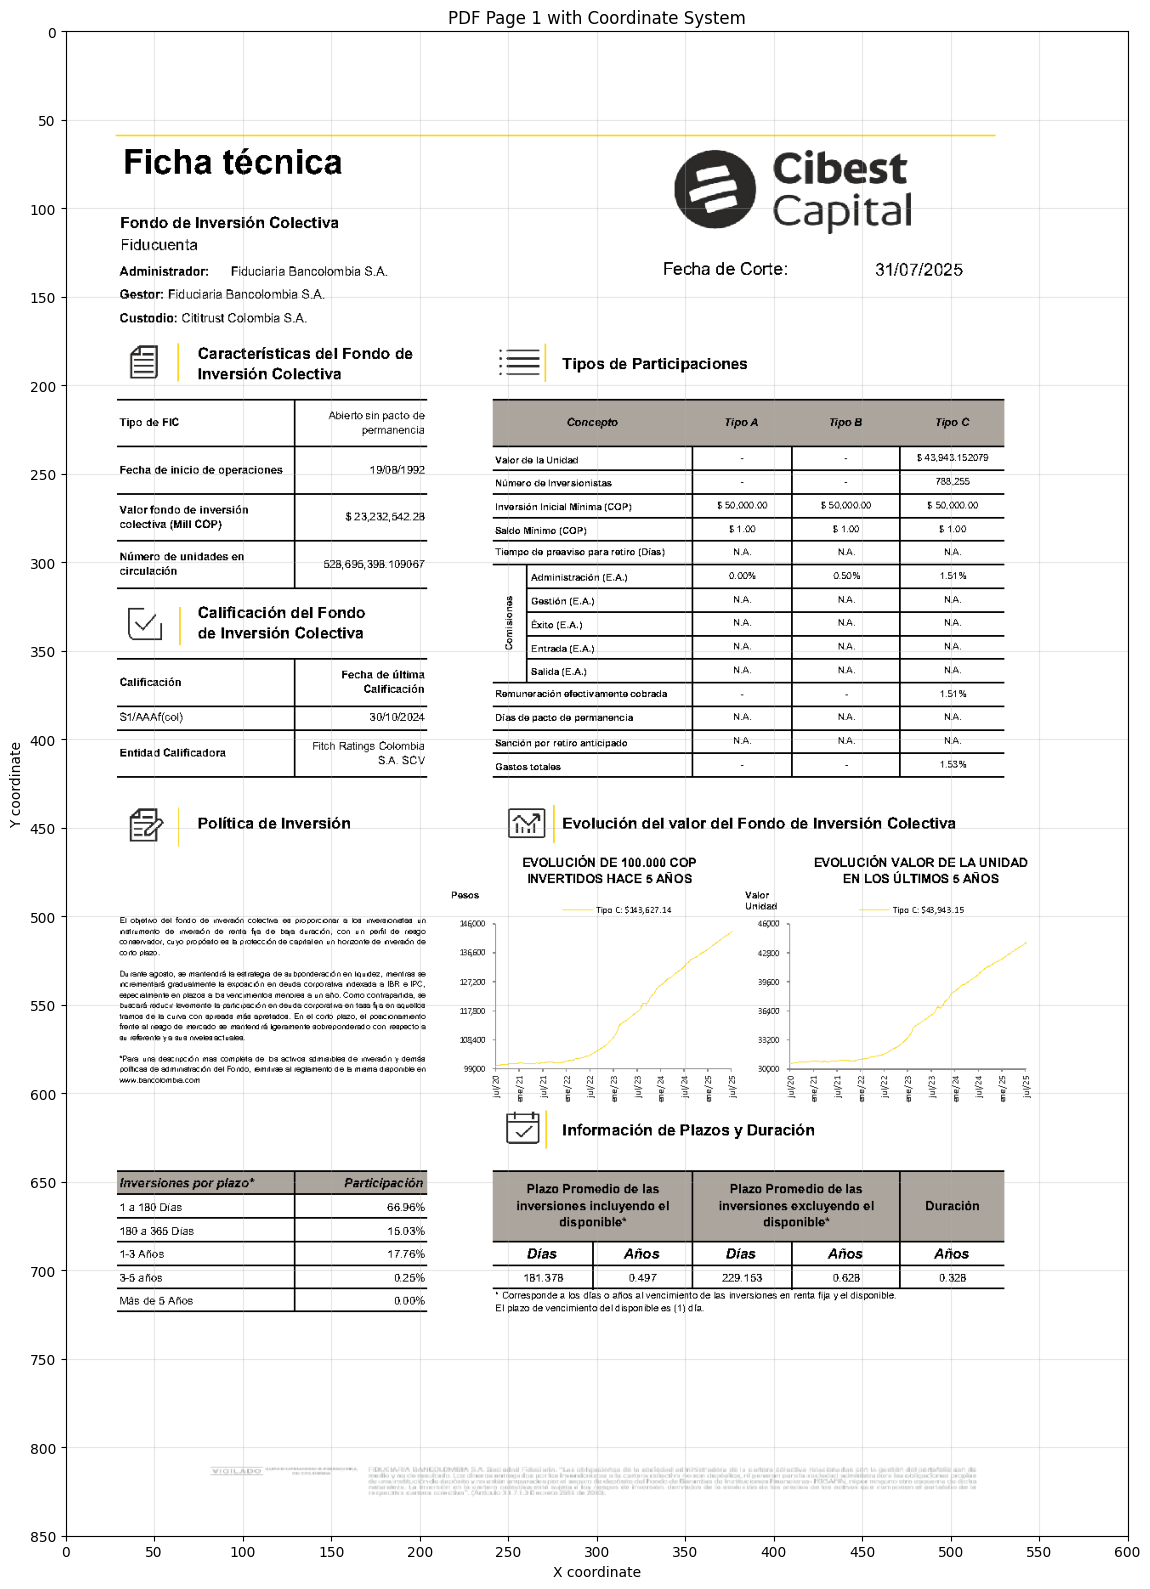


Instructions:
- Use the coordinate system to identify bounding box coordinates
- Bounding boxes format: (x0, top, x1, bottom)
- pdfplumber origin: top-left (0,0), Y increases downward


In [63]:
import pdfplumber
import matplotlib.pyplot as plt
import numpy as np

def show_pdf_page_with_coords(pdf_path, page_number):
    # Abrir PDF y extraer la página
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_number]

        # Convertir la página a imagen completa
        img = page.within_bbox((0, 0, page.width, page.height)).to_image(resolution=150)

        # Obtener dimensiones de la página
        page_width, page_height = page.width, page.height
        print(f"Page dimensions: {page_width} x {page_height}")

        # Crear figura
        fig, ax = plt.subplots(1, 1, figsize=(12, 16))
        ax.imshow(img.original, extent=[0, page_width, page_height, 0], origin='upper')

        # Configurar sistema de coordenadas
        ax.set_xlim(0, page_width)
        ax.set_ylim(page_height, 0)  # Y invertido para coincidir con pdfplumber
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_title(f'PDF Page {page_number + 1} with Coordinate System')

        # Marcas cada 50 unidades
        x_ticks = np.arange(0, page_width + 50, 50)
        y_ticks = np.arange(0, page_height + 50, 50)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        plt.tight_layout()
        plt.show()

        print("\nInstructions:")
        print("- Use the coordinate system to identify bounding box coordinates")
        print("- Bounding boxes format: (x0, top, x1, bottom)")
        print("- pdfplumber origin: top-left (0,0), Y increases downward")

pdf_path = 'unoDeCadaUno/bancolombia_fiducuenta.pdf'
page_number = 0
# Ejemplo de uso
show_pdf_page_with_coords('unoDeCadaUno/bancolombia_fiducuenta.pdf', 0)


In [64]:
# Define your bounding boxes dictionary
# Format: 'field_name': (x0, top, x1, bottom)
# where (x0, top) is top-left corner and (x1, bottom) is bottom-right corner

bounding_boxes = {
    'FIC': (20, 100, 550, 170),
    'Caracteristicas': (20, 175, 210, 320),
    'Calificacion': (20, 325, 210, 425),
    'Politica': (20, 430, 210, 600),
    'PlazoDuracion': (20, 640, 210, 725),
    'TipoParticipacion': (225, 175, 550, 425),
}

# Print the dictionary for verification
print("Defined bounding boxes:")
for field_name, bbox in bounding_boxes.items():
    x0, top, x1, bottom = bbox
    width = x1 - x0
    height = bottom - top
    print(f"{field_name}: {bbox} (width: {width}, height: {height})")

print(f"\nTotal number of bounding boxes defined: {len(bounding_boxes)}")

Defined bounding boxes:
FIC: (20, 100, 550, 170) (width: 530, height: 70)
Caracteristicas: (20, 175, 210, 320) (width: 190, height: 145)
Calificacion: (20, 325, 210, 425) (width: 190, height: 100)
Politica: (20, 430, 210, 600) (width: 190, height: 170)
PlazoDuracion: (20, 640, 210, 725) (width: 190, height: 85)
TipoParticipacion: (225, 175, 550, 425) (width: 325, height: 250)

Total number of bounding boxes defined: 6


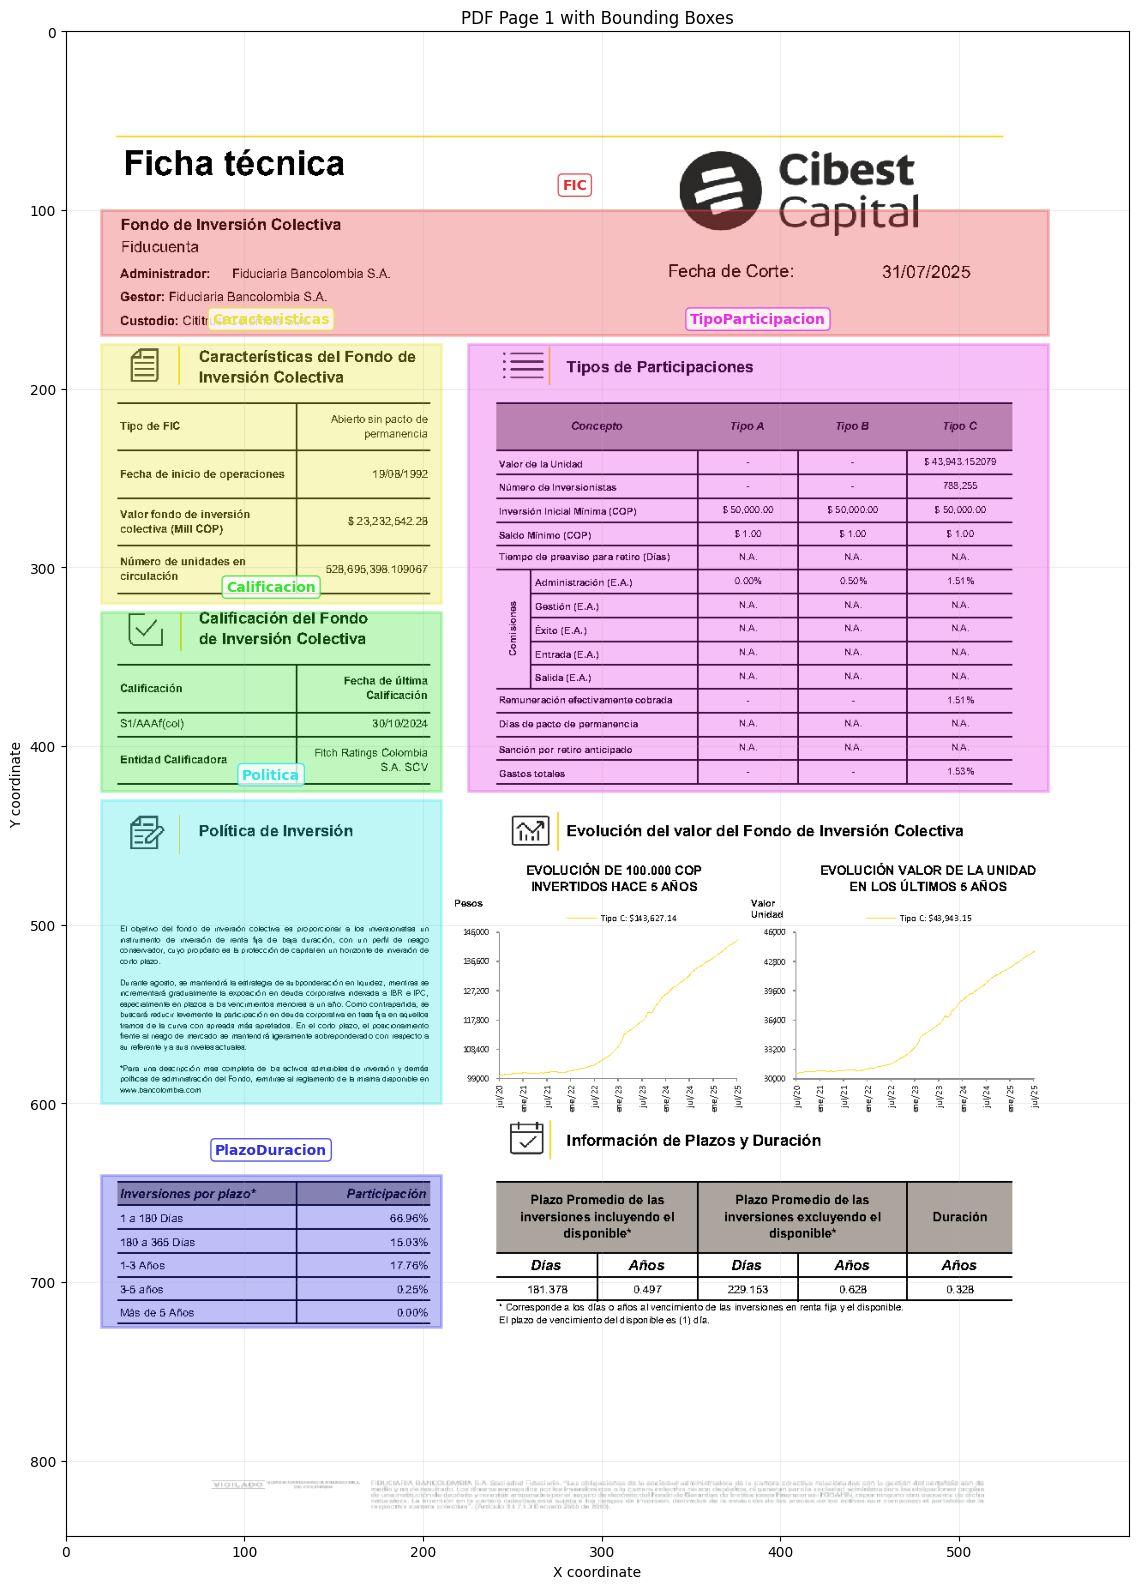


Extracting text from each bounding box:
--------------------------------------------------
FIC: Fondo de Inversión Colectiva Fiducuenta Administrador: Fiduciaria Bancolombia S.A. Fecha de Corte: 3...
Caracteristicas: Características del Fondo de Inversión Colectiva Abierto sin pacto de Tipo de FIC permanencia Fecha ...
Calificacion: de Inversión Colectiva Fecha de última Calificación Calificación S1/AAAf(col) 30/10/2024 Fitch Ratin...
Politica: Política de Inversión Elobjetivodelfondodeinversióncolectivaesproporcionaralosinversionistasun instr...
PlazoDuracion: Inversiones por plazo* Participación 1 a 180 Días 66.96% 180 a 365 Días 15.03% 1-3 Años 17.76% 3-5 a...
TipoParticipacion: Tipos de Participaciones Concepto Tipo A Tipo B Tipo C Valor de la Unidad - - $ 43,943.152079 Número...


In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import hsv_to_rgb

# Open PDF and extract page
with pdfplumber.open(pdf_path) as pdf:
    page = pdf.pages[page_number]

    # Convert page to image
    img = page.within_bbox((0, 0, page.width, page.height)).to_image(resolution=150)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))

    # Display the PDF page image
    ax.imshow(img.original, extent=[0, page.width, page.height, 0], origin='upper')

    # Set up the coordinate system
    ax.set_xlim(0, page.width)
    ax.set_ylim(page.height, 0)  # Inverted Y-axis to match pdfplumber convention

    # Generate colors for each bounding box
    n_boxes = len(bounding_boxes)
    colors = []
    for i in range(n_boxes):
        hue = i / n_boxes
        saturation = 0.8
        value = 0.9
        rgb = hsv_to_rgb([hue, saturation, value])
        colors.append(rgb)

    # Plot each bounding box
    for i, (field_name, bbox) in enumerate(bounding_boxes.items()):
        x0, top, x1, bottom = bbox
        width = x1 - x0
        height = bottom - top

        # Create rectangle patch
        rect = patches.Rectangle(
            (x0, top), width, height,
            linewidth=2,
            edgecolor=colors[i],
            facecolor=colors[i],
            alpha=0.3
        )

        # Add rectangle to plot
        ax.add_patch(rect)

        # Add label
        label_x = x0 + width/2
        label_y = top - 10  # Slightly above the box

        ax.text(label_x, label_y, field_name,
                ha='center', va='bottom',
                fontsize=10, fontweight='bold',
                color=colors[i],
                bbox=dict(boxstyle='round,pad=0.3',
                         facecolor='white',
                         edgecolor=colors[i],
                         alpha=0.8))

    # Labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title(f'PDF Page {page_number + 1} with Bounding Boxes')

    # Add grid for reference
    ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Print extraction preview
    print("\nExtracting text from each bounding box:")
    print("-" * 50)

    for field_name, bbox in bounding_boxes.items():
        # Extract text from the bounding box
        cropped = page.within_bbox(bbox)
        text = cropped.extract_text()

        # Clean up the text
        if text:
            text = text.strip().replace('\n', ' ')
            # Limit text length for display
            if len(text) > 100:
                text = text[:100] + "..."
        else:
            text = "[No text found]"

        print(f"{field_name}: {text}")

## Extraction usando pdfplumber

In [66]:
# Dictionary to store extracted data
extracted_data = {}

# Open PDF and extract data
with pdfplumber.open(pdf_path) as pdf:
    page = pdf.pages[page_number]

    print(f"Extracting data from page {page_number + 1}...")
    print("=" * 60)

    # Extract text from each bounding box
    for field_name, bbox in bounding_boxes.items():
        print(f"\nProcessing: {field_name}")
        print(f"Bounding box: {bbox}")

        # Crop the page to the bounding box
        cropped_area = page.within_bbox(bbox)

        # Extract text from the cropped area
        raw_text = cropped_area.extract_text()

        # Clean and process the text
        if raw_text:
            # Basic text cleaning - preserve line breaks
            cleaned_text = raw_text.strip()

            # Store the extracted data
            extracted_data[field_name] = cleaned_text

            print(f"✓ Text extracted")
        else:
            extracted_data[field_name] = None
            print("⚠ No text found in this area")

print("\n" + "=" * 60)
print("RESULTADOS EXTRAIDOS")
print("=" * 60)

# Display grouped results
for field_name, text_data in extracted_data.items():
    print(f"\n📋 {field_name.upper()}")
    print("-" * 40)
    if text_data:
        print(text_data)
    else:
        print("No se extrajo texto")


Extracting data from page 1...

Processing: FIC
Bounding box: (20, 100, 550, 170)
✓ Text extracted

Processing: Caracteristicas
Bounding box: (20, 175, 210, 320)
✓ Text extracted

Processing: Calificacion
Bounding box: (20, 325, 210, 425)
✓ Text extracted

Processing: Politica
Bounding box: (20, 430, 210, 600)
✓ Text extracted

Processing: PlazoDuracion
Bounding box: (20, 640, 210, 725)
✓ Text extracted

Processing: TipoParticipacion
Bounding box: (225, 175, 550, 425)
✓ Text extracted

RESULTADOS EXTRAIDOS

📋 FIC
----------------------------------------
Fondo de Inversión Colectiva
Fiducuenta
Administrador: Fiduciaria Bancolombia S.A. Fecha de Corte: 31/07/2025
Gestor: Fiduciaria Bancolombia S.A.
Custodio: Cititrust Colombia S.A.

📋 CARACTERISTICAS
----------------------------------------
Características del Fondo de
Inversión Colectiva
Abierto sin pacto de
Tipo de FIC
permanencia
Fecha de inicio de operaciones 19/08/1992
Valor fondo de inversión
$ 23,232,542.28
colectiva (Mill COP)
Nú

## Camelot

altura

In [67]:
import pdfplumber

with pdfplumber.open("unoDeCadaUno/bancolombia_fiducuenta.pdf") as pdf:
    page_height = pdf.pages[0].height  # altura de la página
    print("Altura de la página:", page_height)

Altura de la página: 842.04


convertir las coordenadas

In [68]:
camelot_regions = {}
for name, (x0, top, x1, bottom) in bounding_boxes.items():
    y1 = page_height - bottom
    y2 = page_height - top
    camelot_regions[name] = f"{x0},{y1},{x1},{y2}"

print(camelot_regions)

{'FIC': '20,672.04,550,742.04', 'Caracteristicas': '20,522.04,210,667.04', 'Calificacion': '20,417.03999999999996,210,517.04', 'Politica': '20,242.03999999999996,210,412.03999999999996', 'PlazoDuracion': '20,117.03999999999996,210,202.03999999999996', 'TipoParticipacion': '225,417.03999999999996,550,667.04'}


la extraccion

[de momento estrae super bien TipoParticipacion y plazo duracion]

In [74]:
import camelot


# Paso 4. Iterar para extraer cada tabla por separado
for name, region in camelot_regions.items():
    print(f"\n=== Extrayendo {name} ===")
    tables = camelot.read_pdf(
        "unoDeCadaUno/bancolombia_fiducuenta.pdf",
        pages="1",
        flavor="stream",   # o 'stream' si no hay líneas
        table_regions=[region]
    )
    if tables.n > 0:
        print(tables[0].df)
    else:
        print("No se encontró tabla en esta región.")



=== Extrayendo FIC ===
                                     0                            1  \
0                        Ficha técnica                                
1         Fondo de Inversión Colectiva                                
2                           Fiducuenta                                
3                       Administrador:  Fiduciaria Bancolombia S.A.   
4  Gestor: Fiduciaria Bancolombia S.A.                                
5    Custodio: Cititrust Colombia S.A.                                

                 2           3  
0                               
1                               
2                               
3  Fecha de Corte:  31/07/2025  
4                               
5                               

=== Extrayendo Caracteristicas ===
                                 0                     1
0              Inversión Colectiva                      
1                                   Abierto sin pacto de
2                      Tipo de FIC      

usando lattice solo extrae bien una

In [75]:
import camelot


# Paso 4. Iterar para extraer cada tabla por separado
for name, region in camelot_regions.items():
    print(f"\n=== Extrayendo {name} ===")
    tables = camelot.read_pdf(
        "unoDeCadaUno/bancolombia_fiducuenta.pdf",
        pages="1",
        flavor="lattice",   # o 'stream' si no hay líneas
        table_regions=[region]
    )
    if tables.n > 0:
        print(tables[0].df)
    else:
        print("No se encontró tabla en esta región.")



=== Extrayendo FIC ===
No se encontró tabla en esta región.

=== Extrayendo Caracteristicas ===
No se encontró tabla en esta región.

=== Extrayendo Calificacion ===
No se encontró tabla en esta región.

=== Extrayendo Politica ===
                        0              1
0  Inversiones por plazo*  Participación
1            1 a 180 Días         66.96%
2          180 a 365 Días         15.03%
3                1-3 Años         17.76%
4                3-5 años          0.25%
5           Más de 5 Años          0.00%

=== Extrayendo PlazoDuracion ===
No se encontró tabla en esta región.

=== Extrayendo TipoParticipacion ===
No se encontró tabla en esta región.


## pdfplumber tablas

In [79]:
import pandas as pd

dataframes = {}  # Guardar cada tabla como DataFrame

with pdfplumber.open("unoDeCadaUno/bancolombia_fiducuenta.pdf") as pdf:
    page = pdf.pages[0]  # Ajusta la página si es necesario

    for name, bbox in bounding_boxes.items():
        print(f"\n=== Extrayendo {name} ===")
        cropped = page.within_bbox(bbox)

        # Intentar extraer como tabla
        table = cropped.extract_table()

        if table:
            df = pd.DataFrame(table)
            dataframes[name] = df
            print(df)
        else:
            print("No se detectó tabla en esta región.")


=== Extrayendo FIC ===
No se detectó tabla en esta región.

=== Extrayendo Caracteristicas ===
No se detectó tabla en esta región.

=== Extrayendo Calificacion ===
No se detectó tabla en esta región.

=== Extrayendo Politica ===
No se detectó tabla en esta región.

=== Extrayendo PlazoDuracion ===
                        0              1
0  Inversiones por plazo*  Participación

=== Extrayendo TipoParticipacion ===
                        0            1            2
0                    None            -            -
1                    None            -            -
2                    None  $ 50,000.00  $ 50,000.00
3                    None       $ 1.00       $ 1.00
4                    None         N.A.         N.A.
5   Administración (E.A.)        0.00%        0.50%
6          Gestión (E.A.)         N.A.         N.A.
7            Éxito (E.A.)         N.A.         N.A.
8          Entrada (E.A.)         N.A.         N.A.
9           Salida (E.A.)         N.A.         N.A.
10      

# Page 2

Page dimensions: 594.96 x 842.04


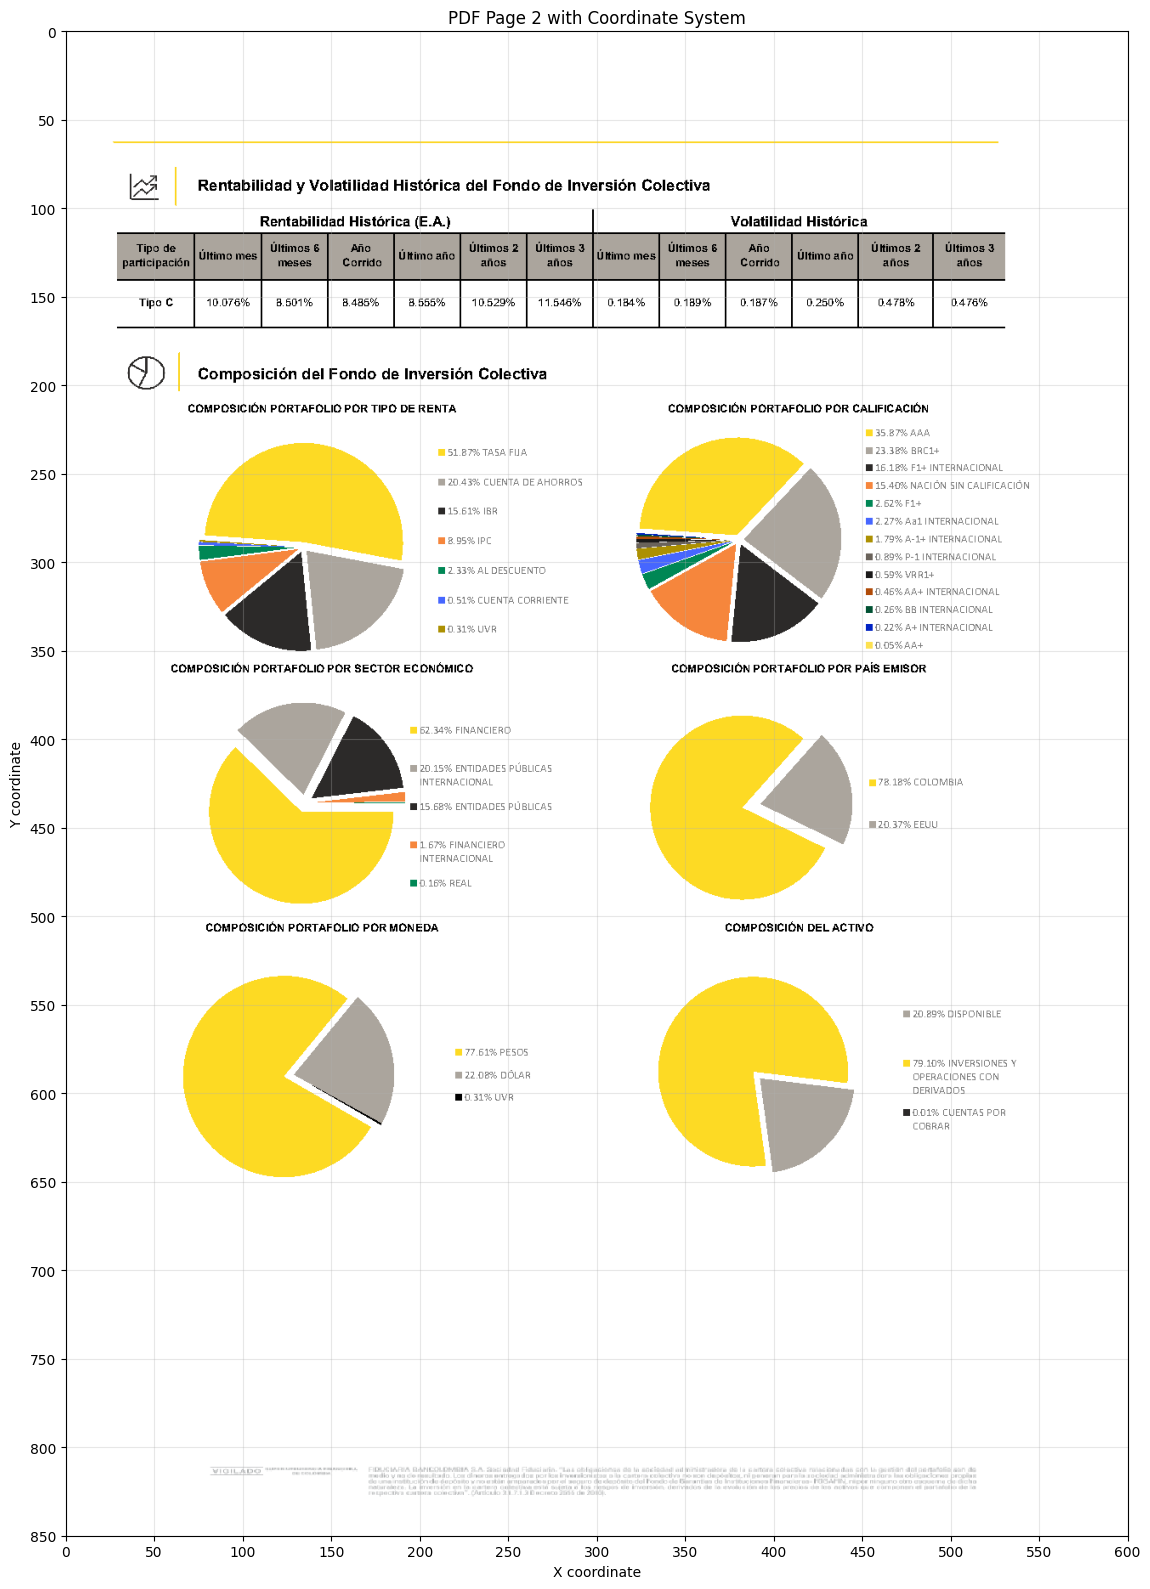


Instructions:
- Use the coordinate system to identify bounding box coordinates
- Bounding boxes format: (x0, top, x1, bottom)
- pdfplumber origin: top-left (0,0), Y increases downward


In [37]:
show_pdf_page_with_coords('unoDeCadaUno/bancolombia_fiducuenta.pdf', 1)

# Page 3